In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import sys
sys.path.insert(0, '../src')

# AT3 - Data Product with Machine Learning

## 3. Modeling

**[3.1]** Import the pandas and numpy package

In [15]:
import pandas as pd
import numpy as np

In [16]:
pd.set_option('display.max_columns', None)

**[3.2]** Load the Merge dataset into a dataframe called df

In [17]:
X_train = pd.read_parquet('../data/processed/X_train.parquet')
X_test = pd.read_parquet('../data/processed/X_test.parquet')
y_train = pd.read_csv('../data/processed/y_train.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

### Baseline Model

**[3.3]** Import the NullRegressor class

In [18]:
from models.predict_model import NullRegressor

**[3.4]** Instantiate a NullRegressor and save it into a variable called base_model

In [19]:
base_model = NullRegressor()

**[3.5]** Make a prediction using fit_predict() and save the results in a variable called y_base

In [20]:
y_base = base_model.fit_predict(y_test)

**[3.6]** Import the function print_regressor_scores and display the RMSE and MAE scores of this baseline model on the testing set

In [21]:
from models.predict_model import print_regressor_scores

In [22]:
print_regressor_scores(y_preds=y_base, y_actuals=y_test, set_name='Testing')

RMSE Testing: 207.69486324362785
MAE Testing: 152.98725613057698


### Linear Regression Model

**[3.7]** Train Linear Regression Model

In [23]:
from sklearn.linear_model import LinearRegression

**[3.8]** Instantiate the `LinearRegression` class

In [24]:
lr = LinearRegression()

**[3.9]** Fit the model and display its performance on the training and validation sets

In [25]:
from models.predict_model import fit_assess_regressor

In [26]:
lr = fit_assess_regressor(lr, X_train, y_train, X_test, y_test)

RMSE Training: 203.39930997758296
MAE Training: 148.23762909041474
RMSE Testing: 203.22642062340867
MAE Testing: 148.17640052696905


**[4.0]** Display the permutations importance of all features

In [39]:
from models.predict_model import permutation_importance

/Users/narongvatchingpayakmon/at3_group_9/notebooks/../src/models/predict_model.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='feature', y='importance', palette='ch:.25')
/Users/narongvatchingpayakmon/at3_group_9/notebooks/../src/models/predict_model.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='feature', y='importance', palette='ch:.25')


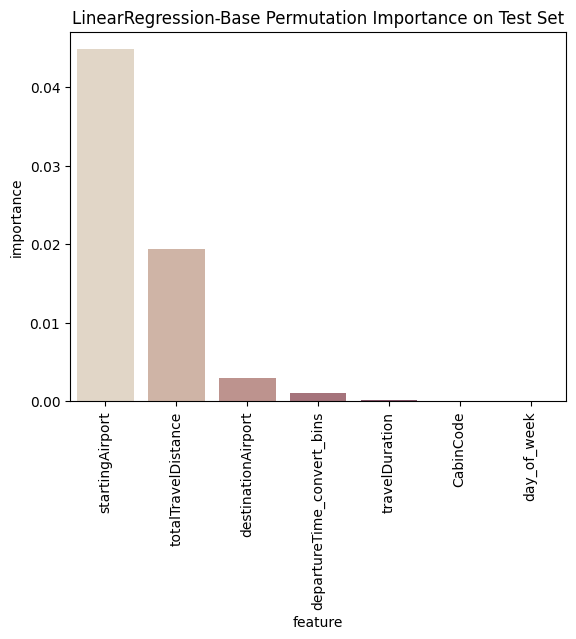

,feature,importance
0,startingAirport,0.044792
1,totalTravelDistance,0.019353
2,destinationAirport,0.003011
3,departureTime_convert_bins,0.001073
4,travelDuration,0.000180
5,CabinCode,0.000019
6,day_of_week,0.000002


In [28]:
permutation_importance(lr, X_test, y_test, 'Test', 'LinearRegression-Base')

### Hyperparameter tuning with Hyperopt

**[4.1]** Import Trials, STATUS_OK, tpe, hp, fmin from hyperopt package

In [29]:
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
rstate = np.random.default_rng(42)

In [31]:
space = {
    'alpha': hp.loguniform('alpha', np.log(1e-5), np.log(1))
}

### Lasso

In [36]:
from sklearn.linear_model import Lasso

def objective(space):
    from sklearn.model_selection import cross_val_score
    from math import sqrt
    
    lasso_regressor = Lasso(alpha=space['alpha'])

    mse = cross_val_score(lasso_regressor, X_train, y_train, scoring='neg_mean_squared_error', cv=5)

    avg_rmse = np.mean(np.sqrt(-mse))

    return {'loss': avg_rmse, 'status': STATUS_OK}

In [33]:
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    rstate=rstate,
)

100%|██████████| 100/100 [22:13<00:00, 13.33s/trial, best loss: 203.39925131961064]


In [34]:
print("Best parameters: ", best)

Best parameters:  {'alpha': 1.000120746792888e-05}


In [35]:
best_params = {
    'alpha': best['alpha']
}

In [37]:
lasso_reg = Lasso(**best_params)

In [38]:
lasso_reg = fit_assess_regressor(lasso_reg, X_train, y_train, X_test, y_test)

RMSE Training: 203.3993099775865
MAE Training: 148.23762909506203
RMSE Testing: 203.22642060619785
MAE Testing: 148.17640053297305


/Users/narongvatchingpayakmon/at3_group_9/notebooks/../src/models/predict_model.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='feature', y='importance', palette='ch:.25')
/Users/narongvatchingpayakmon/at3_group_9/notebooks/../src/models/predict_model.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='feature', y='importance', palette='ch:.25')


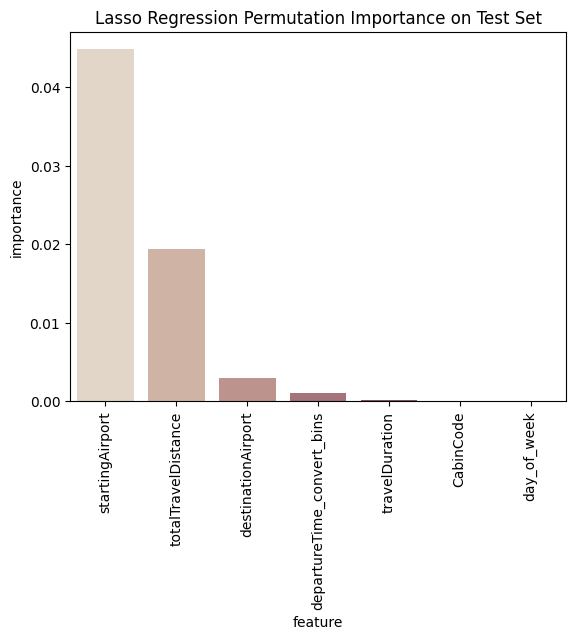

,feature,importance
0,startingAirport,0.044792
1,totalTravelDistance,0.019353
2,destinationAirport,0.003011
3,departureTime_convert_bins,0.001073
4,travelDuration,0.000180
5,CabinCode,0.000019
6,day_of_week,0.000002


In [41]:
permutation_importance(lasso_reg, X_test, y_test, 'Test', 'Lasso Regression')

In [17]:
from joblib import dump

In [18]:
dump(lr, '../models/lr_model.joblib')

['../models/lr_model.joblib']